# Problem 1

First I will define some notation before I write the transition matrix in matrix/vector form.

Let $u_i = 
\begin{cases}
    \frac{1}{r_i},& \text{if } r_i \neq 0\\
    0,              & \text{otherwise}
\end{cases}
$

Let $v_i = 
\begin{cases}
    1,& \text{if } r_i \neq 0\\
    0,              & \text{otherwise}
\end{cases}
$

Let $w_i = 
\begin{cases}
    0,& \text{if } r_i \neq 0\\
    1,              & \text{otherwise}
\end{cases}
$

In scalar notation, 
$$
\begin{align}
p_{ij} &= p * A_{ij} * u_i + \frac{1 - p}{n} * v_i + \frac{1}{n} * w_i\\
& = p * A_{ij} * u_i + \frac{1}{n} - \frac{p}{n}*v_i\\
& = p * A_{ij} * u_i + n^{-1}(1 - p)v_i
\end{align}
$$

Let $\mathbf{u}, \mathbf{v}, \mathbf{w}$ be the corresponding column vectors. Let $1_n$ denote a $n\times 1$ column vector. Let $I_n$ be the $n\times n$ identity matrix.

$$
\begin{align}
P &= p\cdot Diagonal(\mathbf{u}) \cdot A  + n^{-1}[I_n - Diagonal(\mathbf{v})\cdot p]\cdot 1_n 1_n'\\
& = U + z\cdot 1_n'
\end{align}
$$

Where $U$ is a sparse matrix and $z$ is a vector.

# Problem 2

If $\mathbf{P}^{T}\mathbf{x} = \mathbf{x}$, then $(\mathbf{P}^{T} - \mathbf{I})\mathbf{x} = \mathbf{0}$

If we want to constrain $\mathbf{x}$ to have $\sum_{i=1}^{n}x_i = 1$, we can solve the augmented equation $\begin{pmatrix}1_n'\\\mathbf{P}^{T}-\mathbf{I}\end{pmatrix}\mathbf{x} = \begin{pmatrix}1\\0\\\vdots\\0\end{pmatrix}$

In [1]:
# Load in packages
using RCall, WoodburyMatrices, BenchmarkTools

INFO: Recompiling stale cache file C:\Users\John\.julia\lib\v0.5\WoodburyMatrices.ji for module WoodburyMatrices.
INFO: Recompiling stale cache file C:\Users\John\.julia\lib\v0.5\Blosc.ji for module Blosc.
INFO: Recompiling stale cache file C:\Users\John\.julia\lib\v0.5\JLD.ji for module JLD.


In [47]:
# Problem 3

A = readcsv("E:/Classes/BiostatisticsM280/Submissions/biostat-m280-JohnShamshoian/HW3/A.txt");
A = A - Diagonal(A)
websites = readcsv("E:/Classes/BiostatisticsM280/Submissions/biostat-m280-JohnShamshoian/HW3/U.txt")[:, 1]
# Number of pages
print("Number of pages is ", size(A)[1])

# Number of edges
print("\nNumber of edges is ", Int64(sum(A)))

# Number of dangling pages
print("\nNumber of dangling pages is ", size(A)[1] - countnz(sum(A, 2)))

# Page with max in-degree
print("\nThe page with the max in-degree is page ", findin(sum(A, 1), maximum(sum(A, 1))))

# Page with max out-degree
print("\nThe page with the max out-degree is page ", findin(sum(A, 2), maximum(sum(A, 2))))

Number of pages is 500
Number of edges is 10853
Number of dangling pages is 103
The page with the max in-degree is page [1]
The page with the max out-degree is page [36,377,380,381,382,384]

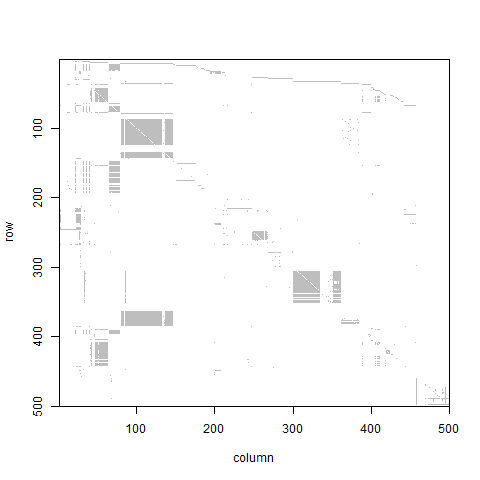

RCall.RObject{RCall.NilSxp}
NULL


In [7]:
# Visualize the sparsity pattern of A. I decided to use R because other Julia packages did not work
# well on my computer. 
@rput A

R"""
library(SparseM)
image(as.matrix.csr(A))
"""

In [36]:
# Problem 4

function transition(A, p)
    n, m = size(A)
    u, v = Array(Float64, 500), Array(Float64, 500)

    for i = 1:500
        if sum(A, 2)[i] == 0.0
            u[i] = 0.0
            v[i] = 0.0
        else
            u[i] = 1.0 / sum(A, 2)[i]
            v[i] = 1.0
        end
    end
    P = p * Diagonal(u) * A + 1 / n * (I - Diagonal(v) * p) * ones(n) * ones(n)'
    U = p * Diagonal(u) * A
    z = 1 / n * (I - Diagonal(v) * p) * ones(n)
    return P, U, z
end

# Read in n by n connectivity matrix

n = size(A)[1]
A = A - Diagonal(A)
p = .85

# Create transition matrix
P, U, z = transition(A, p);

In [142]:
# Have first row sum to one
J = P' - I
J[1, :] = ones(n)
b = vcat(1, zeros(n - 1))

# Dense linear solver
x = lufact!(J) \ b

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

In [38]:
# Dense eigensolver
v = Float64.(eigvecs(P')[:, 1])
# Have the eigenvector sum to 1
v/sum(v)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

In [39]:
# Power method
maxiter = 5000
tol = 1e-10
function power(U, z, maxiter, tol)
    x = rand(500)
    count = 0
    temp = Array{Float64, 500}
    for i = 1:maxiter
        temp = (U' * x + ones(n) .* (z' * x)) / norm(U' * x + ones(n) .* (z' * x))
        temp = temp / sum(temp)
        if norm(x - temp) < tol
            break;
        end
        x = temp
        count = count + 1
    end
    x
end

power(U, z, maxiter, tol)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

In [111]:
# Jacobi method
Full = U' - I + ones(n) * z'
Full[1, :] = ones(n)
D = Diagonal(Full)
J = U' - I
J[1, :] = ones(n)
W = Woodbury(sparse(J), vcat(0, ones(n - 1)), 1.0, z'); 
function Jacobi(D::Diagonal, W::Woodbury, b::Array, maxiter::Int64, tol::Float64)
    x = rand(500)
    count = 0
    for i = 1:maxiter
        temp = - D \ (W * x) + x + D \ b
        temp = temp / sum(temp)
        if norm(temp - x) < tol
            break;
        end
        x = temp
        count = count + 1
    end
    x
end

Jacobi(D, W, b, maxiter, tol)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

.LinAlg.Diagonal, WoodburyMatrices.Woodbury, Array, Int64, Float64) in module Main at In[110]:9 overwritten at In[111]:9.


In [171]:
# Question 5
x = round(x, 8)
sortedx = sort(x, rev = true)
ties = findin(sortedx, sortedx[20])
top20 = Int64.(sortrows([x collect(1:1:500)], rev = true)[1:ties[length(ties)], 2])

# Top 20 websites
websites[top20]

23-element Array{Any,1}:
 "http://schema.org"                                                                     
 "http://www"                                                                            
 "http://www.ucla.edu"                                                                   
 "http://www.directory.ucla.edu"                                                         
 "http://www.universityofcalifornia.edu"                                                 
 "http://schema.org/CreativeWork"                                                        
 "http://schema.org/Text"                                                                
 "http://giveto.ucla.edu"                                                                
 "http://www.registrar.ucla.edu/calendar"                                                
 "http://www.uclalumni.net"                                                              
 "http://www.magazine.ucla.edu/depts/lifesigns/breaking-the-bad"           

In [169]:
ties

5-element Array{Int64,1}:
 19
 20
 21
 22
 23

In [154]:
# Question 6
J = P' - I
J[1, :] = ones(n)
b = vcat(1, zeros(n - 1))
@benchmark lufact(J) \ b
# LU decomposition is fast relatively fast for a 500 by 500 matrix

BenchmarkTools.Trial: 
  memory estimate:  1.92 MiB
  allocs estimate:  8
  --------------
  minimum time:     3.186 ms (0.00% GC)
  median time:      3.356 ms (0.00% GC)
  mean time:        4.079 ms (4.23% GC)
  maximum time:     72.649 ms (0.00% GC)
  --------------
  samples:          1217
  evals/sample:     1

In [155]:
@benchmark Float64.(eigvecs(P')[:, 1])
# A dense eigensolver is extremely slow and will not scale well to big data

BenchmarkTools.Trial: 
  memory estimate:  9.72 MiB
  allocs estimate:  259
  --------------
  minimum time:     104.004 ms (0.00% GC)
  median time:      106.451 ms (0.00% GC)
  mean time:        116.426 ms (0.73% GC)
  maximum time:     176.674 ms (1.04% GC)
  --------------
  samples:          43
  evals/sample:     1

In [157]:
@benchmark power(U, z, maxiter, tol)
# The power method is the fastest. It can scale to big data since each iteration costs O(n) flops

BenchmarkTools.Trial: 
  memory estimate:  1.85 MiB
  allocs estimate:  883
  --------------
  minimum time:     2.379 ms (0.00% GC)
  median time:      2.986 ms (0.00% GC)
  mean time:        3.239 ms (6.75% GC)
  maximum time:     7.174 ms (37.08% GC)
  --------------
  samples:          1530
  evals/sample:     1

In [159]:
@benchmark Jacobi(D, W, b, maxiter, tol)
# Jacobi method is slow but faster than a dense eigensolver

BenchmarkTools.Trial: 
  memory estimate:  45.27 MiB
  allocs estimate:  15877
  --------------
  minimum time:     26.821 ms (7.69% GC)
  median time:      27.497 ms (7.72% GC)
  mean time:        29.876 ms (10.38% GC)
  maximum time:     35.791 ms (18.04% GC)
  --------------
  samples:          168
  evals/sample:     1

A teraflop supercomputer can compute  $10^{12}$ flops per second.

1. The dense LU decomposition requires $\approx \frac{2}{3}n^3$ flops. The LU decomposition for 4.49 billion website requires $\frac{2}{3}(4.49\cdot 10^{9})^{3} \approx 60 \cdot 10^{27}$
 It would take a teraflop supercomputer $60\cdot 10^{15}$ seconds, or about 2 billion years.
 
2. Jacobi method has the potential to be much faster since it's in an iterative algorithm and can take advantage of a structured matrix (like sparsity). In practice, the Jacobi method requires a large number of iterations to converge. In the small set of 500 websites, my Jacobi method needed 1133 iterations, which is large.  

3. A dense eigensolver requires even more flops then the dense LU decomposition. A dense eigensolver will be impractical for large dataset.

4. The power method costs $\mathcal{O}(n)$ flops per iteration. The benchmark also showed this was the fastest algorithm. This algorithm can work for Google pagerank problem.

90.51884900000002